In [2]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from typhon import plots
import xarray as xr
from scipy import integrate
from scipy import optimize

import konrad

plots.styles.use('typhon')

In [3]:
cp_air = 1004.64 #J kg-1 K-1
g = 9.81 #m s-2
Ra = 287.0570048852906 #J kg-1 K-1 air
print(konrad.constants.Rv)
Rv = 461.52280830495 #J kg-1 K-1 water vapor
Lv = 2.5E6 #J kg-1
eps = Ra/Rv #dimensionless
e_sat_ref = 610.94 #Pa, saturation water vapor pressure for Tref = 273.15 K
T_ref = 273.15 #K
seconds_day = 24*60*60 #seconds in a day

lapse_dry = -g/cp_air #K/m

461.52280830495


In [4]:
#WATER

def manabe_rh(rhs, p):
    rh = np.maximum(0,rhs*(p/p[0]-0.02)/(1-0.02))
    return rh

def fixed_rh(rhs,p):
    rh = np.ones_like(p)*rhs
    return rh

def w_sat_p(T): #Pa
    e_sat = e_sat_ref * np.exp(-Lv/Rv*(1/T-1/T_ref))
    return e_sat

def mmr_sat(T,p): #kg/kg
    r_sat = eps*w_sat_p(T)/p
    return r_sat

def vmr_sat(T,p): #m3/m3
    r_sat = w_sat_p(T)/p
    return r_sat
    
def rh_to_mmr(rh,T,p):
    mixing_saturation = mmr_sat(T,p)
    mixing_ratio = np.maximum(5e-6,rh*mixing_saturation)
    
    return mixing_ratio

def rh_to_vmr(rh,T,p):
    mixing_ratio = np.maximum(5e-6,konrad.physics.relative_humidity2vmr(rh,p,T))
    
    return mixing_ratio

def vmr_to_rh(vmr,T,p):
    relative_humidity = konrad.physics.vmr2relative_humidity(vmr,p,T)
    
    return relative_humidity

def vmr_to_mmr(vmr):
    mass_mix = vmr*eps
    
    return mass_mix

def energy_to_water(energy):#kg m-2
    #if energy is in J s-1 m-2, comes back as kg s-1 m-2, ie, mm s-1 of precipitation
    # mass_atm = (p[0]-p[-1])/g
    mass_w = energy/Lv #* mass_atm
    return mass_w

In [5]:
#AIR

def height(p,T): #m
    rho = p/(Ra*T)
    z = integrate.cumulative_trapezoid(-1/(g*rho),p,initial = 0)
    return z

def MALR(T,p): #dlnT/dlnp
    r_sat = mmr_sat(T,p)
    A = (Lv*r_sat)/(Ra*T)
    B = (Lv**2*r_sat)/(cp_air*Ra*T**2)
    moist_lapse = - g/cp_air * (1+A)/(1+B)
    return moist_lapse

def T_MA(T_bl,p): #K
    T_atm = np.zeros((len(p)))
    T_atm[0] = T_bl
    for i in range(len(p)-1):
        lapse_z = MALR(T_atm[i],p[i])
        lapse_p = lapse_pressure(lapse_z)
        T_atm[i+1]=T_atm[i]*(p[i+1]/p[i])**(lapse_p)
    return T_atm

def lapse_pressure(lapse_z): #dlnT/dlnp, dT/dz
    l_p = -Ra/g * lapse_z
    return l_p


def T_atm_z(T_bl,z,lapse_z):
    Temp = T_bl + z*lapse_z
    return Temp

def T_atm_p(T_bl,p,lapse_p):
    Temp = T_bl * (p/p_s)**(lapse_p)
    return Temp

def moist_adiabat(p,T_bl,T_rad):
    T_moist_ad = konrad.lapserate.get_moist_adiabat(p,T_bl,T_min=0.)
    T_con = np.maximum(T_moist_ad,T_rad)
    
    return T_con

In [6]:
#FIRE

def TE(T,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass #J kg-1

def DSE(T,z,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass #J kg-1

def PE(z):
    energy = integrate.trapz(-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass

def T_bl_TE(thermal_energy, p, T_rad): #find T_bl conserving thermal energy
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl


def T_convection_TE(p, T_rad): #find T after convective adjustment conserving thermal energy
    thermal_energy = TE(T_rad,p)
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm,p)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    T_con = moist_adiabat(p,T_bl,T_rad)
    return T_con


def T_convection_DSE(p, T_rad): #find T after convective adjustment conserving dry static energy
    z_rad = height(p,T_rad)
    dry_static_energy = DSE(T_rad,z_rad,p)
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        z_atm = height(p,T_atm)
        DSE_moist = DSE(T_atm,z_atm,p)
        res = DSE_moist-dry_static_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl

In [23]:
#EARTH

wind = 10 # wind speed m s-1
Cd = 0.002 # Drag coefficient unitless

def sensible_heat(T_bl,T_s,p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Ra*T_bl) #kg m-3
    sh = wind*Cd*rho_s*cp_air*(T_s-T_bl) #J s-1 m-2
    
    return sh

def latent_heat(vmr, T_bl, p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Ra*T_bl) #kg m-3
    
    rh = konrad.physics.vmr2relative_humidity(vmr,p_s,T_bl)
    mmr = vmr_to_mmr(vmr)
    mmr_sat = mmr/rh
    
    lh = wind*Cd*rho_s*Lv*(mmr_sat-mmr) #J s-1 m-2
    return lh

    
def SH_to_ws(T_bl,T_s,p_s,sh):
    rho_s = p_s/(Ra*T_bl) #kg m-3
    windspeed = sh/(Cd*rho_s*cp_air*(T_s-T_bl))
    
    return windspeed

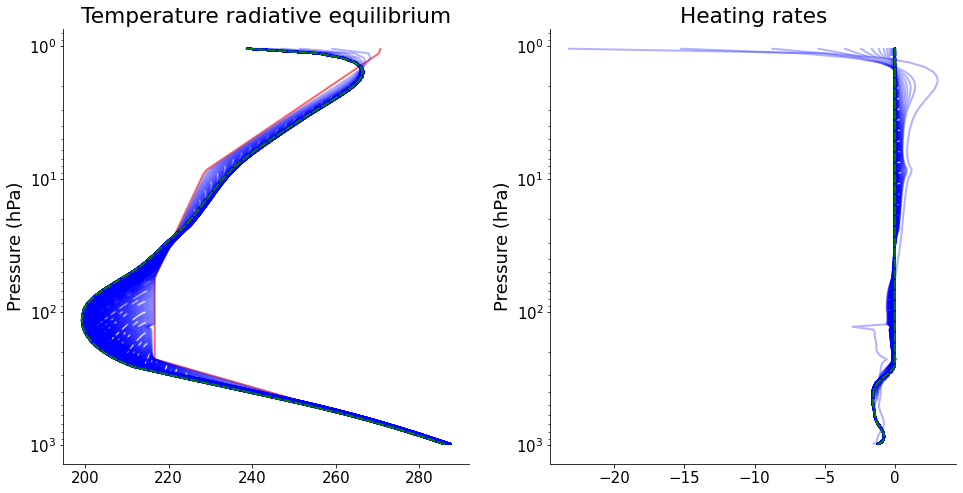

surface T [286.55184405]
toa radiation [67.50351328]
toa -67.5035132819296
surface radiation 168.000146320751
latent heat [71.92336958]
sensible heat [6.8163274]
daily evaporation [2.48567165]


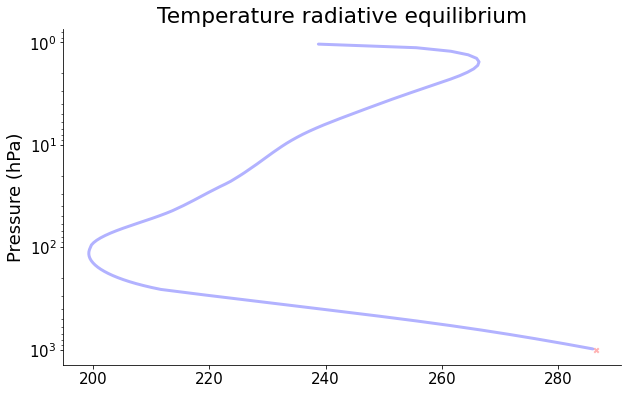

In [13]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )

heat_sink = surface.heat_sink

radiation = konrad.radiation.RRTMG()
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

RH = manabe_rh(0.77,atmosphere['plev'])

ndays = 500
timestep = 0.5 #days
nsteps = int(ndays/timestep)

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_yscale('log')
ax[0].yaxis.set_inverted(True)
ax[0].set_title('Temperature radiative equilibrium')
ax[0].set_ylabel('Pressure (hPa)')



ax[1].set_yscale('log')
ax[1].set_title('Heating rates')
ax[1].set_ylabel('Pressure (hPa)')
ax[1].yaxis.set_inverted(True)

ax[0].plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.6, color = 'red')

for i in range(nsteps):
    #update radiaitve fluxes and heating rates
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky) 

    #net radiation at surface
    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
    
    SH = sensible_heat(atmosphere['T'][0,0],surface['temperature'],atmosphere['phlev'][0])
    SH = 0.
    
    LH = latent_heat(atmosphere['H2O'][0,0], surface['temperature'],atmosphere['phlev'][0])
    
    surface['temperature'] += ((net_rad_surface - LH - SH)
                               * seconds_day * timestep / surface.heat_capacity)
    
    old_T_s = surface['temperature']
    
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += radiation['net_htngrt'] * timestep
    atmosphere['T'][0,0] += SH * seconds_day * timestep / (cp_air * mass_bl)
    
    T_radiation = atmosphere['T'][0]
    
    old_T_bl = T_radiation[0]
    
    convection.stabilize(
                atmosphere=atmosphere,
                lapse=lapserate,
                timestep=timestep,
                surface=surface,
            ) 
    
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'])
    
    trans = 0.3 #+0.6*(i/nsteps)**8
    ax[0].plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.3, color = 'blue')

    
    ax[1].plot(radiation['net_htngrt'][0], atmosphere['plev']/100,
               alpha = 0.3, color = 'blue')

ax[0].plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 1, color = 'green')

    
ax[1].plot(radiation['net_htngrt'][0], atmosphere['plev']/100,
               alpha = 1, color = 'green')

plt.show()

print('surface T',surface['temperature'])
print('toa radiation',radiation['toa'])
print('toa',-(radiation['lw_flxd'][0,-1] + radiation['sw_flxd'][0,-1] - 
                    (radiation['lw_flxu'][0,-1] + radiation['sw_flxu'][0,-1])))
print('surface radiation',net_rad_surface)
print('latent heat', LH)
print('sensible heat', SH)
print('daily evaporation',energy_to_water(LH)*seconds_day)

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature radiative equilibrium')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = trans, color = 'blue', lw = 3)
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = trans, color = 'red', s = 20, marker ='x')
plt.show()

first with LH, then with heat sink:
surface T [287.56998701] 287.23727024234887
toa radiation [65.13409298] [64.53620353]
surface radiation 168.7171043159966 168.5681710781119
latent heat 0.0
sensible heat 0.0
daily evaporation 0.0


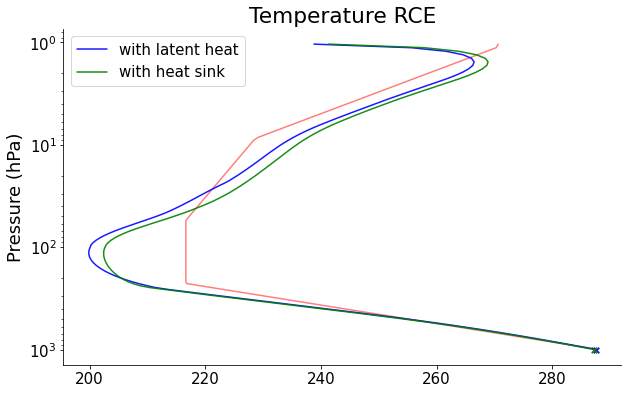

In [20]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

RH = manabe_rh(0.77,atmosphere['plev'])

ndays = 1000
timestep = 0.5 #days
nsteps = int(ndays/timestep)


fig, ax = plt.subplots()
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.5, color = 'red', lw = 1.5)

for i in range(nsteps):
    #update heating rates
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)

    #update net radiaiton at surface
    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
#    SH = sensible_heat(atmosphere['T'][0,0],surface['temperature'],atmosphere['phlev'][0])
    SH = 0.
    
    LH = latent_heat(atmosphere['H2O'][0,0], surface['temperature'],atmosphere['phlev'][0])
    LH = 0.
    
    heat_sink = 66
#    heat_sink = 0.
    
    #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - LH - SH - heat_sink)
                               * seconds_day * timestep / surface.heat_capacity)
    
    old_T_s = surface['temperature']
    
    #update atmosphere temperature with energetic fluxes (radiative)
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += radiation['net_htngrt'] * timestep
    atmosphere['T'][0,0] += SH * seconds_day * timestep / (cp_air * mass_bl)
    
    #temperature of atmosphere after radiative update
    T_radiation = atmosphere['T'][0]
    
    old_T_bl = T_radiation[0]
    
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    convection.stabilize(
                atmosphere=atmosphere,
                lapse=lapserate,
                timestep=timestep,
                surface=surface,
            )
    
    SH = (old_T_s - surface['temperature'])*surface.heat_capacity/(timestep*seconds_day)
    wind_speed = SH_to_ws(old_T_bl,old_T_s,atmosphere['phlev'][0],SH)
    
#    plt.plot(wind_speed, i*timestep)
    
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'])

    
atmosphere_rce = konrad.atmosphere.Atmosphere(phlev)
surface_rce = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink = 66,
)

humidity_model = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(),
)
rce = konrad.RCE(
    atmosphere_rce,
    surface=surface_rce,  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration=ndays, # Set maximum runtime.
    humidity = humidity_model
)
rce.run()

print('first with LH, then with heat sink:')
print('surface T',surface['temperature'],surface_rce['temperature'][0])
print('toa radiation',radiation['toa'],rce.radiation['toa'])
rad_surf_rce = (rce.radiation['lw_flxd'][0,0] + rce.radiation['sw_flxd'][0,0] - 
                    (rce.radiation['lw_flxu'][0,0] + rce.radiation['sw_flxu'][0,0]))
print('surface radiation',net_rad_surface, rad_surf_rce)
print('latent heat', LH)
print('sensible heat', SH)
print('daily evaporation',energy_to_water(LH)*seconds_day)


ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature RCE')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'blue', lw = 1.5, label = 'my h2o adjustment')
ax.plot(atmosphere_rce['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'green', lw = 1.5, label = 'full konrad')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'blue', s = 30, marker ='x')
ax.scatter(surface_rce['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'green', s = 30, marker ='x')
plt.legend()
plt.show()

214506875.0
43200.0
282.02440517983854
282.9351164261101
282.94102238409994
282.94612690013594
282.95059157286937
282.9544115322451
282.95765995706336
282.9604400272749
282.9629030881504
282.9650233400812
282.96689750397235
282.96855374584254
282.9701221543368
282.9714663550392
282.9727244411099
282.9738976489298
282.9749249063976
282.97588152825875
282.97679962146583
282.9776700970033
282.97846858812346
282.97927273152584
282.9799546798891
282.98055150301417
282.9811360523924
282.98171651287635
282.982283840656
282.98284509143525
282.983377724197
282.9838828702185
282.98438349831554
282.98485074094697
282.98524250661
282.9856186838257
282.98598044046025
282.98633936739475
282.98665409662425
282.98695523863
282.9872483277803
282.9875482672053
282.987803698843
282.9880616298085
282.98831286257564
282.98855274240555
282.9887633561964
282.98890082130475
282.9890815916756
282.98923198716466
282.98937561246584
282.9895214739414
282.98966169679966
282.98979047785605
282.9898905980284
282.989

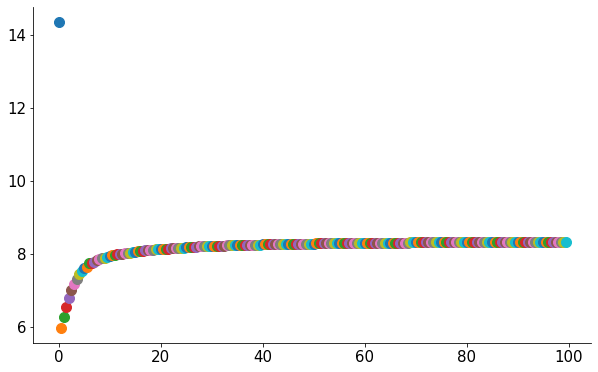

In [24]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

print(surface.heat_capacity)

RH = manabe_rh(0.77,atmosphere['plev'])

ndays = 100
timestep = 0.5 #days
nsteps = int(ndays/timestep)

print(timestep*seconds_day)

for i in range(nsteps):
    #update heating rates
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)

    #update net radiaiton at surface
    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
#    SH = sensible_heat(atmosphere['T'][0,0],surface['temperature'],atmosphere['phlev'][0])
    SH = 0.
    
    LH = latent_heat(atmosphere['H2O'][0,0], surface['temperature'],atmosphere['phlev'][0])
    LH = 0.
    
    heat_sink = 66
#    heat_sink = 0.
    
    #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - LH - SH - heat_sink)
                               * seconds_day * timestep / surface.heat_capacity)
    
    old_T_s = surface['temperature'].copy()
    #update atmosphere temperature with energetic fluxes (radiative)
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += radiation['net_htngrt'] * timestep
    atmosphere['T'][0,0] += SH * seconds_day * timestep / (cp_air * mass_bl)
    
    #temperature of atmosphere after radiative update
    T_radiation = atmosphere['T'][0].copy()
    
    old_T_bl = np.sum(T_radiation[:8])/8
    print(old_T_bl)
    
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    convection.stabilize(
                atmosphere=atmosphere,
                lapse=lapserate,
                timestep=timestep,
                surface=surface,
            )
    
    SH = (old_T_s - surface['temperature'])*surface.heat_capacity/(timestep*seconds_day)
    wind_speed = SH_to_ws(old_T_bl,old_T_s,atmosphere['phlev'][0],SH)
    
    plt.scatter(i*timestep,wind_speed)
    
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'])
    
plt.show()

In [25]:
atmosphere['z']

array([[  115.16905004,   347.83525922,   583.02645281,   820.69322319,
         1060.78537008,  1303.25189994,  1548.0410252 ,  1795.1001637 ,
         2044.37593797,  2295.81417455,  2549.35990338,  2804.9573571 ,
         3062.54997038,  3322.08037927,  3583.49042053,  3846.72113095,
         4111.7127467 ,  4378.40470263,  4646.73563165,  4916.64336403,
         5188.06492671,  5460.9365427 ,  5735.19363031,  6010.77080258,
         6287.60186653,  6565.61982253,  6844.75686361,  7124.94437481,
         7406.11293247,  7688.19230358,  7971.11144511,  8254.79850332,
         8539.1808131 ,  8824.18489726,  9109.73646591,  9395.76041573,
         9682.18082932,  9968.92097453, 10255.90330375, 10543.04945327,
        10830.28024255, 11117.5156736 , 11407.3633133 , 11700.00751148,
        11995.44944747, 12293.69030109, 12594.73125266, 12898.57348298,
        13205.21817339, 13514.66650568, 13826.91966216, 14141.97882564,
        14459.84517944, 14780.51990735, 15104.00419367, 15430.29